# General Overview - Statistical Analysis

- Are there variables that are particularly significant in terms of explaining the answer to your project question?
- Are there significant differences between subgroups in your data that may be relevant to your project aim?
- Are there strong correlations between pairs of independent variables or between an independent and a dependent variable?
- What are the most appropriate tests to use to analyze these relationships?

Some categorical variables are nominal attributes, meaning that the variables in each column are independent of each other (i.e. no sense of order). Others are binary and have only two answer choices: Yes and No.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm, t, chisquare
from scipy.stats import chi2_contingency
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8') # import data
tree = data.copy() # save a copy of data as tree

In [3]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651535 entries, 0 to 651534
Data columns (total 22 columns):
tree_id         651535 non-null int64
tree_dbh        651535 non-null int64
curb_loc        651535 non-null object
health          651535 non-null object
spc_common      651535 non-null object
steward         651535 non-null object
guards          651535 non-null object
sidewalk        651535 non-null object
problems        651535 non-null object
root_stone      651535 non-null object
root_grate      651535 non-null object
root_other      651535 non-null object
trunk_wire      651535 non-null object
trnk_light      651535 non-null object
trnk_other      651535 non-null object
brch_light      651535 non-null object
brch_shoe       651535 non-null object
brch_other      651535 non-null object
borough         651535 non-null object
longitude       651535 non-null float64
latitude        651535 non-null float64
num_problems    651535 non-null int64
dtypes: float64(2), int64(3), ob

In [4]:
# looking at sample data

tree.head()

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


In [5]:
tree.shape

(651535, 22)

The problems column is reflected in the adjacent 9 columns so we are removing it from our dataset along with longitude and latitude since they are used to map the location of the trees. We do not need the latitude and longitude columns either since they are used to map the location of the tree, see data storytelling for the maps. Finally, we are removing tree_id since the trees are identified using their index number.

In [6]:
col_remove = ['tree_id', 'problems', 'longitude', 'latitude'] # columns to remove

tree = tree.drop(col_remove, axis=1)

In [7]:
# cleaned up dataset

tree.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,num_problems
0,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,0
1,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,1
2,3,OnCurb,Good,honeylocust,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,0
3,10,OnCurb,Good,honeylocust,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1
4,21,OnCurb,Good,American linden,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,1


# Statistical Testing - Chi-Square Test for Association

We use the chi-square test for association to determine any statistical significance between variables.

## Curb Location (curb_loc)

In [8]:
# Null Hypothesis: There is no relationship between health and curb_loc (independent).
# Alternate Hypothesis: There is a relationship between health and curb_loc (not independent).
# p-value: 0.05

# using the crosstab function

curb_loc_table = pd.crosstab(tree.curb_loc, [tree.health])
display(curb_loc_table)

health,Fair,Good,Poor
curb_loc,,,
OffsetFromCurb,4022,20814,963
OnCurb,92405,507513,25818


In [9]:
# calcuate expected values

offset_total = len(tree[tree.curb_loc == 'OffsetFromCurb'])
oncurb_total = len(tree[tree.curb_loc == 'OnCurb'])
good_total = len(tree[tree.health == 'Good'])
fair_total = len(tree[tree.health == 'Fair'])
poor_total = len(tree[tree.health == 'Poor'])
grand_total = len(tree)

print('Offset From Curb Total: ', offset_total)
print('On Curb Total: ', oncurb_total)
print('Good Total: ', good_total)
print('Fair Total: ', fair_total)
print('Poor Total: ', poor_total)
print('Grand Total: ', grand_total)

offset_good = (offset_total * good_total) / grand_total
offset_fair = (offset_total * fair_total) / grand_total
offset_poor = (offset_total * poor_total) / grand_total
oncurb_good = (oncurb_total * good_total) / grand_total
oncurb_fair = (oncurb_total * fair_total) / grand_total
oncurb_poor = (oncurb_total * poor_total) / grand_total

Offset From Curb Total:  25799
On Curb Total:  625736
Good Total:  528327
Fair Total:  96427
Poor Total:  26781
Grand Total:  651535


In [10]:
# calculate chi-square values using observed and expected values

observed = [20814, 4022, 963, 507513, 92405, 25818] # offset good, fair, poor, oncurb good, fair, poor
expected = [offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor]

values = []

for e, o in enumerate(observed):
    sig = (o - expected[e])**2 / expected[e]
    values.append(sig)
    
chisq_curb_loc = sum(values)
print('Chi-squared value: ', chisq_curb_loc)

Chi-squared value:  21.208951781289166


Next, we find a p-value associated with the chi-squared value that tells us if the difference between the observed and associated values are statistically significant.

In [11]:
# using chisquare

observed = np.array([20814, 4022, 963, 507513, 92405, 25818]) # offset good, fair, poor, oncurb good, fair, poor
expected = np.array([offset_good, offset_fair, offset_poor, oncurb_good, oncurb_fair, oncurb_poor])

chisquare_value, pvalue = chisquare(observed, expected)

print('Chi-squared value: ', chisquare_value) # confirmed!
print('p-value: ', pvalue)

Chi-squared value:  21.208951781289166
p-value:  0.0007396291269688524


The calculated p-value of 0.0007 tells us that we can reject the null hypothesis and accept the alternate hypothesis that there is a relationship between the curb location and tree health.

## Stewardship

In [12]:
# Null Hypothesis: There is no relationship between health and steward.
# Alternate Hypothesis: There is a relationship between health and steward.
# p-value: 0.05

# using the crosstab function

steward_table = pd.crosstab(tree.steward, [tree.health])
display(steward_table)

health,Fair,Good,Poor
steward,,,
1or2,21883,115231,6276
3or4,2829,15594,747
4orMore,200,1360,49
None,71515,396142,19709


In [13]:
# using a shortcut, chi2_contingency

chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  82.64204316499212
p-value:  1.0158580809907348e-15


## Guards

In [14]:
# Null Hypothesis: There is no relationship between health and guards.
# Alternate Hypothesis: There is a relationship between health and guards.
# p-value: 0.05

guard_table = pd.crosstab(tree.guards, [tree.health])
display(guard_table)

health,Fair,Good,Poor
guards,,,
Harmful,3836,15313,1091
Helpful,7159,42602,2061
None,84057,464503,23169
Unsure,1375,5909,460


In [15]:
chisq_value, pvalue, df, expected = chi2_contingency(guard_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  575.1113270237256
p-value:  5.43997022022521e-121


## Sidewalk Condition

In [16]:
# Null Hypothesis: There is no relationship between health and sidewalks.
# Alternate Hypothesis: There is a relationship between health and sidewalks.
# p-value: 0.05

sidewalk_table = pd.crosstab(tree.sidewalk, [tree.health])
display(sidewalk_table)

health,Fair,Good,Poor
sidewalk,,,
Damage,28676,151750,6593
NoDamage,67751,376577,20188


In [17]:
chisq_value, pvalue, df, expected = chi2_contingency(sidewalk_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  268.98082116629007
p-value:  3.9044225721239635e-59


## Borough

In [18]:
# Null Hypothesis: There is no relationship between health and borough.
# Alternate Hypothesis: There is a relationship between health and borough.
# p-value: 0.05

borough_table = pd.crosstab(tree.borough, [tree.health])
display(borough_table)

health,Fair,Good,Poor
borough,,,
Bronx,10879,66546,3092
Brooklyn,25060,138119,6454
Manhattan,11456,47338,3607
Queens,34512,193789,9401
Staten Island,14520,82535,4227


In [19]:
chisq_value, pvalue, df, expected = chi2_contingency(borough_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # very safe to reject the null hypothesis

Chi-square value:  1387.3756826254964
p-value:  3.0368189425788952e-294


## Tree Type (spc_common)

In [20]:
# Null Hypothesis: There is no relationship between health and the type of tree.
# Alternate Hypothesis: There is a relationship between health and the type of tree.
# p-value: 0.05

spc_common_table = pd.crosstab(tree.spc_common, [tree.health])
display(spc_common_table.head(10))

health,Fair,Good,Poor
spc_common,,,
'Schubert' chokecherry,717,3927,242
American beech,38,213,21
American elm,1293,6404,266
American hophornbeam,158,866,57
American hornbeam,203,1220,93
American larch,8,37,1
American linden,1944,10838,742
Amur cork tree,38,121,24
Amur maackia,280,1811,105


In [21]:
chisq_value, pvalue, df, expected = chi2_contingency(spc_common_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject the null hypothesis

Chi-square value:  16810.881359034953
p-value:  0.0


There are 132 unique kinds of trees. The number of trees vastly outnumber the answer types for the other columns so we are choosing not to use spc_common as a factor for our model.

In [22]:
print('Number of unique trees:', len(tree.spc_common.unique()))

Number of unique trees: 132


## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

In [23]:
# these 9 columns are similar to each other (binaries) so we are creating a function to handle all of them at once

root_trunk_branch = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

rt_tk_bh_values = []

for x in root_trunk_branch:
    table = pd.crosstab(tree[x], [tree.health])
    chisq_value, pvalue, df, expected = chi2_contingency(table)
    rt_tk_bh_values.extend(('Column: ' + x, 'Chi-square: ', chisq_value, 'p-value:', pvalue, '-----------'))

In [24]:
display(rt_tk_bh_values)

['Column: root_stone',
 'Chi-square: ',
 602.1719849387213,
 'p-value:',
 1.7378604199012528e-131,
 '-----------',
 'Column: root_grate',
 'Chi-square: ',
 356.68976230775087,
 'p-value:',
 3.5140039001739447e-78,
 '-----------',
 'Column: root_other',
 'Chi-square: ',
 1928.3000460610629,
 'p-value:',
 0.0,
 '-----------',
 'Column: trunk_wire',
 'Chi-square: ',
 511.1079115744369,
 'p-value:',
 1.0335397233161574e-111,
 '-----------',
 'Column: trnk_light',
 'Chi-square: ',
 42.65188376759023,
 'p-value:',
 5.473449537752943e-10,
 '-----------',
 'Column: trnk_other',
 'Chi-square: ',
 11787.16656714847,
 'p-value:',
 0.0,
 '-----------',
 'Column: brch_light',
 'Chi-square: ',
 410.2875656415676,
 'p-value:',
 8.07582918010992e-90,
 '-----------',
 'Column: brch_shoe',
 'Chi-square: ',
 35.43604272124426,
 'p-value:',
 2.01911517512005e-08,
 '-----------',
 'Column: brch_other',
 'Chi-square: ',
 15111.455650416505,
 'p-value:',
 0.0,
 '-----------']

The p-values all show that there is statistical significance between each of the nine columns and tree health.

## Tree Variable Table

In [25]:
pd.crosstab([tree.sidewalk, tree.borough, tree.health], [tree.steward, tree.guards, tree.curb_loc])

steward                                 1or2                               \
guards                               Harmful               Helpful          
curb_loc                      OffsetFromCurb OnCurb OffsetFromCurb OnCurb   
sidewalk borough       health                                               
Damage   Bronx         Fair                0     38              4    116   
                       Good                0    151             14    586   
                       Poor                0     17              1     36   
         Brooklyn      Fair               30    295              5    468   
                       Good               26   1186             19   2707   
                       Poor                1     65              0     99   
         Manhattan     Fair                9    343              3    420   
                       Good                9   1154             14   1665   
                       Poor                2     78              1    140   
         Queens        Fair                1    228              1    149   
                       Good                1    801              4    821   
                       Poor                0     77              0     46   
         Staten Island Fair                0     38              0     55   
                       Good                0    140              6    224   
                       Poor                0      6              0     10   
NoDamage Bronx         Fair                1     49             14    298   
                       Good                2    240             56   1978   
                       Poor                0     27              3     71   
         Brooklyn      Fair               14    348             14   1096   
                       Good               26   1448            184   7173   
                       Poor                1     93              5    267   
         Manhattan     Fair               27    689             34   1280   
                       Good               75   2604            299   6178   
                       Poor                3    220             10    448   
         Queens        Fair                2    231             15    462   
                       Good                4   1095             40   2961   
                       Poor                0    108              0    145   
         Staten Island Fair                0     94              2    161   
                       Good                7    481             47   1294   
                       Poor                0     33              0     27   

steward                                                                    \
guards                                  None                Unsure          
curb_loc                      OffsetFromCurb OnCurb OffsetFromCurb OnCurb   
sidewalk borough       health                                               
Damage   Bronx         Fair               12    395              0     12   
                       Good               64   1915              0     65   
                       Poor                3    111              0      2   
         Brooklyn      Fair               54   1052              0     54   
                       Good              265   5745              2    368   
                       Poor               12    272              0     18   
         Manhattan     Fair               10    348              0     57   
                       Good               56   1150              2    156   
                       Poor                4     91              0     19   
         Queens        Fair               36    956              0    137   
                       Good              114   5582              5    553   
                       Poor                5    253              0     59   
         Staten Island Fair               15    378              2     39   
                       Good               43   1919              1     8

# Analyzing Diameter Distributions

We use a 2-sample t-test in order to determine if there is any significance between the averages of two population means.

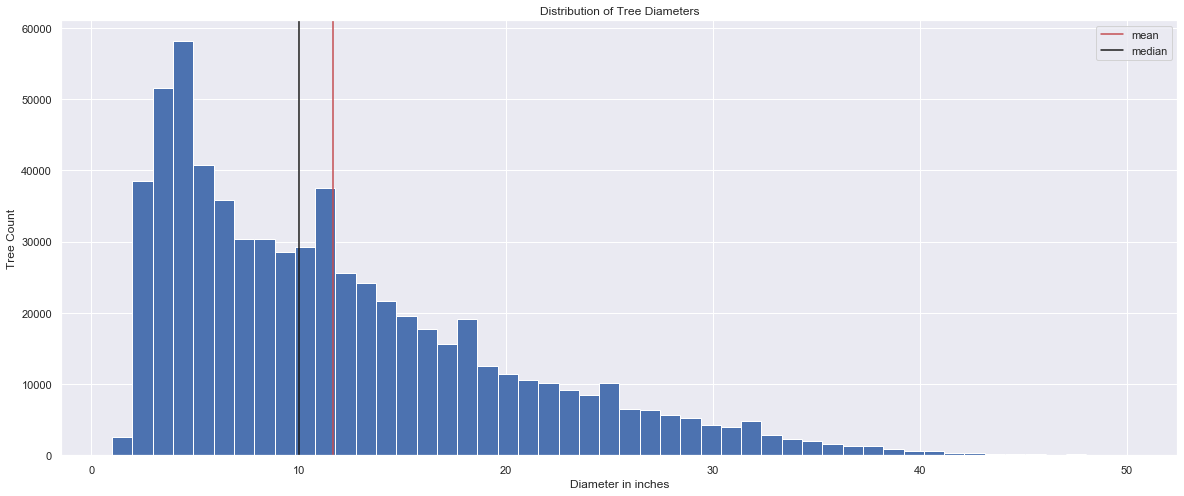

In [26]:
plt.figure(figsize=(20, 8))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.axvline(np.mean(tree.tree_dbh), color='r', label='mean')
plt.axvline(np.median(tree.tree_dbh), color='k', label='median')
plt.legend()
plt.show()

In [27]:
# printing the mean and median

rp.summary_cont(tree.tree_dbh)

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,tree_dbh,651535.0,11.674665,8.366295,0.010365,11.65435,11.69498


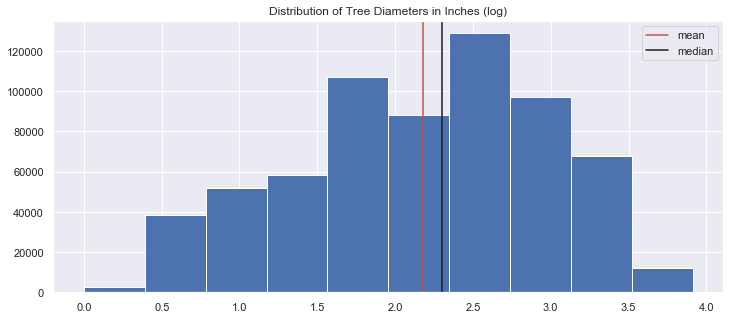

In [28]:
# take the log of tree_dbh

dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(12, 5))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.axvline(np.mean(dbh_log), color='r', label='mean')
plt.axvline(np.median(dbh_log), color='k', label='median')
plt.legend()
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

In [29]:
# diameter (inches) distribution

tree.groupby('health')['tree_dbh'].describe()

,count,mean,std,min,25%,50%,75%,max
health,,,,,,,,
Fair,96427.0,10.954370,7.61766,1.0,5.0,9.0,15.0,50.0
Good,528327.0,11.942466,8.53741,1.0,5.0,10.0,17.0,50.0
Poor,26781.0,8.985064,6.74574,1.0,4.0,7.0,12.0,50.0


In [30]:
rp.summary_cont(tree.groupby('health')['tree_dbh'])

,N,Mean,SD,SE,95% Conf.,Interval
health,,,,,,
Fair,96427,10.954370,7.61766,0.024531,10.906288,11.002451
Good,528327,11.942466,8.53741,0.011746,11.919444,11.965487
Poor,26781,8.985064,6.74574,0.041221,8.904270,9.065858


In [31]:
# group diameters according to tree health

health_good = tree[tree.health == 'Good']['tree_dbh']
health_fair = tree[tree.health =='Fair']['tree_dbh']
health_poor = tree[tree.health == 'Poor']['tree_dbh']

# bootstrap functions to draw samples from

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    return np.array([bootstrap_replicate_1d(data, func) for x in range(size)])

In [32]:
# comparing good and fair trees

mean_good = np.mean(health_good)
mean_fair = np.mean(health_fair)
mean_poor = np.mean(health_poor)

# draw bootstrap reps
bs_reps_good = draw_bs_reps(health_good, np.mean, size=10000)
bs_reps_fair = draw_bs_reps(health_fair, np.mean, size=10000)
bs_reps_poor = draw_bs_reps(health_poor, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_good = np.percentile(bs_reps_good, [2.5, 97.5])
conf_int_fair = np.percentile(bs_reps_fair, [2.5, 97.5])
conf_int_poor = np.percentile(bs_reps_poor, [2.5, 97.5])

# Print the results
print("""
good:  mean = {0:.3f} min., conf. int. = [{1:.2f}, {2:.2f}] min.
fair: mean = {3:.4f} min., conf. int. = [{4:.2f}, {5:.2f}] min.
poor: mean = {6:.4f} min., conf. int. = [{7:.2f}, {8:.2f}] min.
""".format(mean_good, *conf_int_good, mean_fair, *conf_int_fair, mean_poor, *conf_int_poor))


good:  mean = 11.942 min., conf. int. = [11.92, 11.97] min.
fair: mean = 10.9544 min., conf. int. = [10.91, 11.00] min.
poor: mean = 8.9851 min., conf. int. = [8.91, 9.07] min.



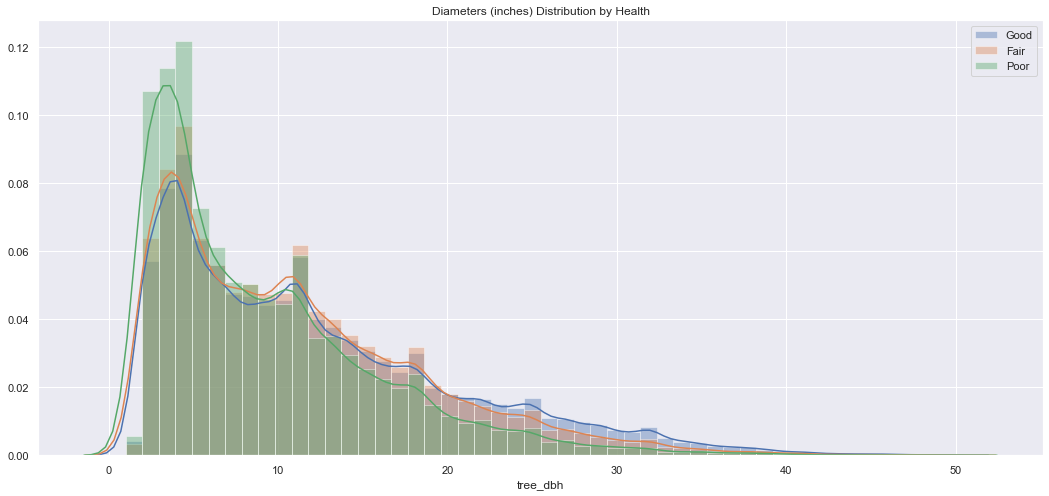

In [33]:
# plotting the distribution of diameters

plt.figure(figsize=(18, 8))
sns.distplot(health_good, label='Good')
sns.distplot(health_fair, label='Fair')
sns.distplot(health_poor, label='Poor')
plt.title('Diameters (inches) Distribution by Health')
plt.legend()
plt.show()

Since we are comparing three groups of trees (Good, Fair, Poor), we will use the analysis of variance, or ANOVA, test as an extension to the t-test.

While conducting this test, we will sample from our groups so that each group has the same size by randomly sampling 10,000 data points for each set.

In [34]:
anova_bs_reps_good = draw_bs_reps(health_good, np.mean, size=10000)
anova_bs_reps_fair = draw_bs_reps(health_fair, np.mean, size=10000)
anova_bs_reps_poor = draw_bs_reps(health_poor, np.mean, size=10000)

In [35]:
# multiple hypothesis testing

stats.f_oneway(anova_bs_reps_good, anova_bs_reps_fair, anova_bs_reps_poor)

F_onewayResult(statistic=28179491.430387743, pvalue=0.0)

The [f-statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) is large and our p-value is small, which means that there is statistical significance between these groups.

In [36]:
## find the mean difference

## Analyzing Problems Distribution

We use a 2-sample t-test in order to determine any significance between two population means.

In [37]:
tree.groupby('health')['num_problems'].describe()

,count,mean,std,min,25%,50%,75%,max
health,,,,,,,,
Fair,96427.0,0.643658,0.872558,0.0,0.0,0.0,1.0,7.0
Good,528327.0,0.430014,0.710553,0.0,0.0,0.0,1.0,7.0
Poor,26781.0,0.684328,0.980530,0.0,0.0,0.0,1.0,9.0


In [38]:
rp.summary_cont(tree.groupby('health')['num_problems'])

,N,Mean,SD,SE,95% Conf.,Interval
health,,,,,,
Fair,96427,0.643658,0.872558,0.002810,0.638150,0.649165
Good,528327,0.430014,0.710553,0.000978,0.428098,0.431930
Poor,26781,0.684328,0.980530,0.005992,0.672585,0.696072


In [39]:
pd.crosstab(tree.health, [tree.num_problems])

num_problems,0,1,2,3,4,5,6,7,8,9
health,,,,,,,,,,
Fair,53915,27984,10436,3275,717,84,15,1,0,0
Good,356491,127845,34377,8011,1479,105,18,1,0,0
Poor,15486,6579,2901,1414,324,59,16,0,1,1


In [40]:
# group according to tree health

probs_good = tree[tree.health == 'Good']['num_problems']
probs_fair = tree[tree.health =='Fair']['num_problems']
probs_poor = tree[tree.health == 'Poor']['num_problems']

In [41]:
# find the mean of each group

mean_probs_good = np.mean(probs_good)
mean_probs_fair = np.mean(probs_fair)
mean_probs_poor = np.mean(probs_poor)

# draw bootstrap reps
bs_reps_probs_good = draw_bs_reps(probs_good, np.mean, size=10000)
bs_reps_probs_fair = draw_bs_reps(probs_fair, np.mean, size=10000)
bs_reps_probs_poor = draw_bs_reps(probs_poor, np.mean, size=10000)

# Compute 95% confidence intervals
conf_int_probs_good = np.percentile(bs_reps_probs_good, [2.5, 97.5])
conf_int_probs_fair = np.percentile(bs_reps_probs_fair, [2.5, 97.5])
conf_int_probs_poor = np.percentile(bs_reps_probs_poor, [2.5, 97.5])

# Print the results
print("""
good:  mean = {0:.3f} min., conf. int. = [{1:.2f}, {2:.2f}] min.
fair: mean = {3:.4f} min., conf. int. = [{4:.2f}, {5:.2f}] min.
poor: mean = {6:.4f} min., conf. int. = [{7:.2f}, {8:.2f}] min.
""".format(mean_probs_good, *conf_int_probs_good, mean_probs_fair, *conf_int_probs_fair, mean_probs_poor, *conf_int_probs_poor))


good:  mean = 0.430 min., conf. int. = [0.43, 0.43] min.
fair: mean = 0.6437 min., conf. int. = [0.64, 0.65] min.
poor: mean = 0.6843 min., conf. int. = [0.67, 0.70] min.



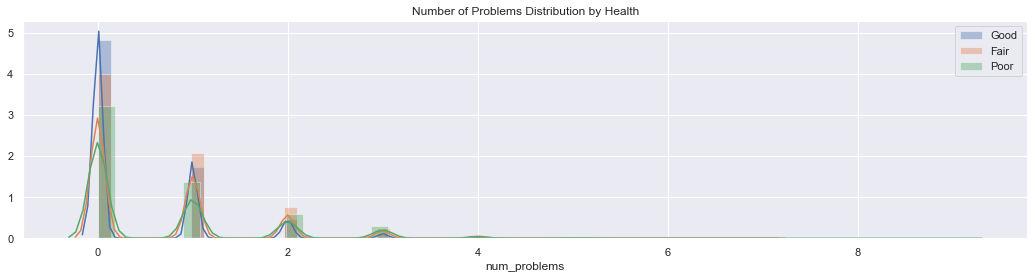

In [42]:
# plotting problems distribution

plt.figure(figsize=(18, 4))
sns.distplot(probs_good, label='Good')
sns.distplot(probs_fair, label='Fair')
sns.distplot(probs_poor, label='Poor')
plt.title('Number of Problems Distribution by Health')
plt.legend()
plt.show()

In [43]:
anova_bs_reps_probs_good = draw_bs_reps(probs_good, np.mean, size=10000)
anova_bs_reps_probs_fair = draw_bs_reps(probs_fair, np.mean, size=10000)
anova_bs_reps_probs_poor = draw_bs_reps(probs_poor, np.mean, size=10000)

In [44]:
# multiple hypothesis testing

stats.f_oneway(anova_bs_reps_probs_good, anova_bs_reps_probs_fair, anova_bs_reps_probs_poor)

F_onewayResult(statistic=12477184.085540265, pvalue=0.0)

While the number of problems a tree has decreases as the problems increases, after 7 problems, two poor trees have 8 or 9 problems. Overall, there are far less poor trees than good or fair trees.

In [45]:
# comparing health and tree problems

pd.crosstab([tree.health, tree.root_stone, tree.root_grate, tree.root_other, tree.trunk_wire], 
                    [tree.trnk_light, tree.trnk_other, tree.brch_light, tree.brch_shoe, tree.brch_other])

trnk_light                                              No                \
trnk_other                                              No                 
brch_light                                              No                 
brch_shoe                                               No       Yes       
brch_other                                              No   Yes  No Yes   
health root_stone root_grate root_other trunk_wire                         
Fair   No         No         No         No           53915  2848  19   4   
                                        Yes            753    80   0   0   
                             Yes        No            2111   465   2   0   
                                        Yes             47    12   0   1   
                  Yes        No         No             433    90   2   0   
                                        Yes             11     1   0   0   
                             Yes        No              38    14   0   0   
                                        Yes              0     0   0   0   
       Yes        No         No         No           14124  1156  17   3   
                                        Yes            266    26   2   0   
                             Yes        No             761   189   5   1   
                                        Yes              8     8   0   0   
                  Yes        No         No              40     5   0   0   
                                        Yes              2     0   0   0   
                             Yes        No               7     2   0   0   
                                        Yes              0     0   0   0   
Good   No         No         No         No          356491  4560  77   8   
                                        Yes           3155   202   3   0   
                             Yes        No            8810   883   7   0   
                                        Yes            268    39   0   0   
                  Yes        No         No            1555    94   2   0   
                                        Yes             23     3   0   0   
                             Yes        No             103    24   0   0   
                                        Yes              1     3   0   0   
       Yes        No         No         No           78594  2330  72  12   
                                        Yes           1139    60   1   0   
                             Yes        No            3569   500   8   0   
                                        Yes            113    19   0   0   
                  Yes        No         No             157    13   1   0   
                                        Yes              9     0   0   0   
                             Yes        No              26     1   0   0   
                                        Yes              0     0   0   0   
Poor   No         No         No         No           15486   940   7   1   
                                        Yes            184    32   1   0   
                             Yes        No             486   155   1   0   
                                        Yes              9     4   0   0   
                  Yes        No         No             110    24   0   0   
                                        Yes              0     1   0   0   
                             Yes        No              18     8   0   0   
                                        Yes              0     0   0   0   
       Yes        No         No         No            2858   298   7   2   
                                        Yes             50    13   0   0   
                             Yes        No             132    54   0   0   
                                        Yes              3     5   0   0   
                  Yes        No         No              10     1   0   0   
                                        Yes              2     2   0   0   
                             Yes        No      

# Encoding Categorical Data - Label Encoder

In [46]:
# create a table specifically for label encoding

tree_label = tree.copy()

## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

We'll start by looking at the root, trunk, and branch columns. Since each of these columns contain simple Yes or No options, we create a new column with labels indicating **0 for No and 1 for Yes**.

In [47]:
# transform and map root_stone

rs_le = LabelEncoder()
rs_labels = rs_le.fit_transform(tree_label.root_stone)
tree_label['root_stone_labels'] = rs_labels

In [48]:
# transform and map problems columns

cols_transform = ['root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for x in cols_transform:
    lencode = LabelEncoder()
    tree_label[x + '_labels'] = lencode.fit_transform(tree_label[x])

In [49]:
# display columns with labels

tree_label[['root_stone', 'root_stone_labels', 'root_grate', 'root_grate_labels', 'root_other', 'root_other_labels', 
            'trunk_wire', 'trunk_wire_labels', 'trnk_light', 'trnk_light_labels', 'trnk_other', 'trnk_other_labels', 
            'brch_light', 'brch_light_labels', 'brch_shoe', 'brch_shoe_labels', 'brch_other', 'brch_other_labels']].head()

,root_stone,root_stone_labels,root_grate,root_grate_labels,root_other,root_other_labels,trunk_wire,trunk_wire_labels,trnk_light,trnk_light_labels,trnk_other,trnk_other_labels,brch_light,brch_light_labels,brch_shoe,brch_shoe_labels,brch_other,brch_other_labels
0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
1,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
2,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
3,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0
4,Yes,1,No,0,No,0,No,0,No,0,No,0,No,0,No,0,No,0


## Health

In [50]:
# choosing to manually map the numerical value to a variable response

health_map = {'Poor': 0, 'Fair': 1, 'Good': 2}

tree_label['health_labels'] = tree_label['health'].map(health_map)
tree_label[['health', 'health_labels']].head()

,health,health_labels
0,Fair,1
1,Fair,1
2,Good,2
3,Good,2
4,Good,2


In [51]:
# just the labeled columns

tree_label = tree_label[['health_labels', 'num_problems', 'tree_dbh', 
                         'root_stone_labels', 'root_grate_labels', 'root_other_labels', 
                         'trunk_wire_labels', 'trnk_light_labels', 'trnk_other_labels', 
                         'brch_light_labels', 'brch_shoe_labels', 'brch_other_labels']]

tree_label.head()

,health_labels,num_problems,tree_dbh,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,brch_light_labels,brch_shoe_labels,brch_other_labels
0,1,0,3,0,0,0,0,0,0,0,0,0
1,1,1,21,1,0,0,0,0,0,0,0,0
2,2,0,3,0,0,0,0,0,0,0,0,0
3,2,1,10,1,0,0,0,0,0,0,0,0
4,2,1,21,1,0,0,0,0,0,0,0,0


In [52]:
tree_label.shape

(651535, 12)

In [53]:
round(tree_label.describe(), 2)

,health_labels,num_problems,tree_dbh,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,brch_light_labels,brch_shoe_labels,brch_other_labels
count,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00,651535.00
mean,1.77,0.47,11.67,0.21,0.01,0.05,0.02,0.00,0.05,0.10,0.00,0.04
std,0.51,0.75,8.37,0.41,0.07,0.21,0.14,0.04,0.22,0.29,0.03,0.19
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2.00,0.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2.00,1.00,16.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,2.00,9.00,50.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Encoding Categorical Data - One Hot Encoder / Dummy Variables

We are encoding the data using one-hot encoder.

In [54]:
# convert using get_dummies, columns of interest: curb_loc, steward, guards, sidewalk, borough

steward_dum = pd.get_dummies(tree.steward)
curb_loc_dum = pd.get_dummies(tree.curb_loc)
guards_dum = pd.get_dummies(tree.guards)
sidewalk_dum = pd.get_dummies(tree.sidewalk)
borough_dum = pd.get_dummies(tree.borough)

In [55]:
tree_onehot = pd.concat([steward_dum, curb_loc_dum, guards_dum, sidewalk_dum, borough_dum], axis=1)

tree_onehot.head()

,1or2,3or4,4orMore,None,OffsetFromCurb,OnCurb,Harmful,Helpful,None,Unsure,Damage,NoDamage,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0
2,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0
3,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0


# Combining the Columns

In [56]:
tree_encode = pd.concat([tree.health, tree_label, tree_onehot], axis=1)

In [57]:
tree_encode.head(10)

,health,health_labels,num_problems,tree_dbh,root_stone_labels,root_grate_labels,root_other_labels,trunk_wire_labels,trnk_light_labels,trnk_other_labels,...,Helpful,None,Unsure,Damage,NoDamage,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,Fair,1,0,3,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
1,Fair,1,1,21,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,Good,2,0,3,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,Good,2,1,10,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,Good,2,1,21,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
5,Good,2,0,11,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
6,Good,2,0,11,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
7,Good,2,1,9,0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
8,Good,2,0,6,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
9,Fair,1,0,21,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0


# Correlation Between Variables

In [58]:
# if there is a relationship between two variables, drop one of them
# machine learning assumes all variables are independent

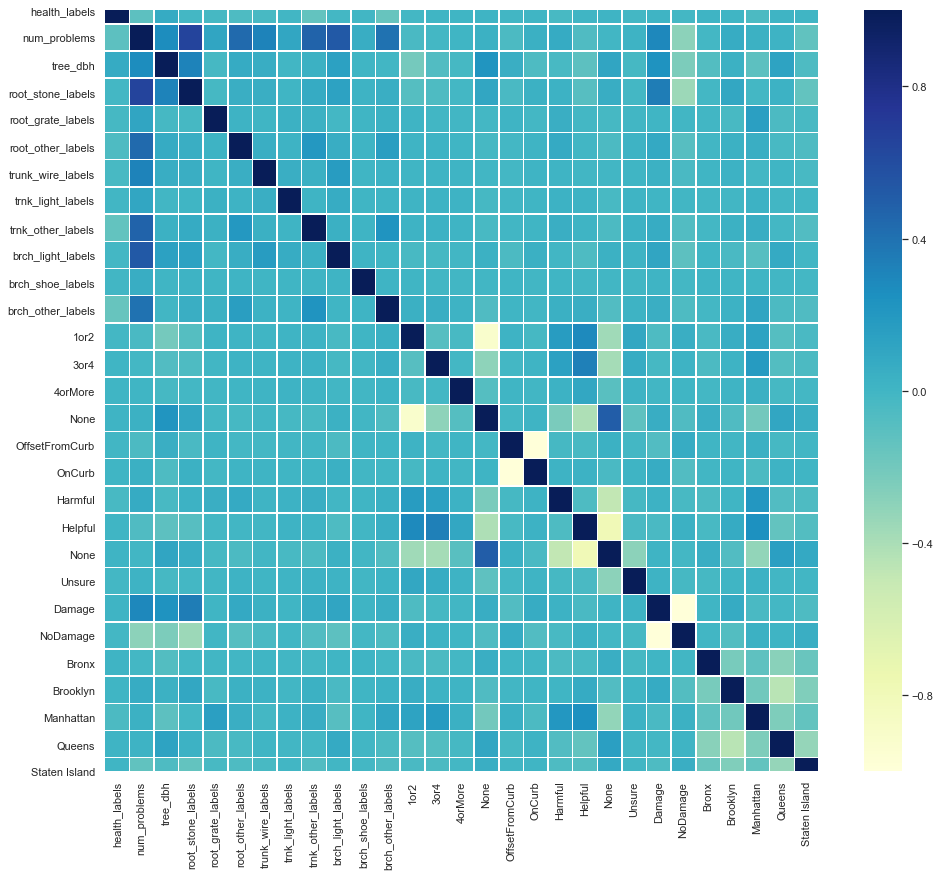

In [59]:
tree_corr = tree_encode.drop(columns='health')

plt.figure(figsize=(16,14))
sns.heatmap(tree_corr.corr(), center=0, cmap="YlGnBu", linewidths=.5)
plt.show()

# Next Steps

In [60]:
# save encoded data to new file for machine learning

# tree_encode.to_csv('tree_ml.csv')